In [27]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Loading data

In [28]:
image_path = 'data/task_2/images/'
mask_path = 'data/task_2/masks/'
files_X = os.listdir(image_path)
files_Y = os.listdir(mask_path)

In [29]:
# Loading the image and mask files
X = []
for i in tqdm(files_X):
    img = np.array(Image.open(image_path+i).convert('L')) 
    X.append(img)
    
y = []
for i in tqdm(files_Y):
    msk = np.array(Image.open(mask_path+i)) 
    y.append(msk)

100%|██████████| 30/30 [00:00<00:00, 136.72it/s]


# Preprocessing of the image and mask

In [30]:
input_size = (572,572)
output_size = (388,388)

def transform_images(X,y,input_size, output_size):
    X_dash = []
    y_dash = []
    
    for i in range(len(X)):
        img = X[i]
        img = cv2.resize(img, input_size)
        img = np.expand_dims(img, axis=2)
        X_dash.append(img)

    for i in range(len(y)):
        msk = y[i]
        msk = cv2.resize(msk, output_size)
        msk = np.expand_dims(msk, axis=2)
        msk = msk/255
        y_dash.append(msk)
        
    return np.array(X_dash), np.array(y_dash)

In [31]:
X,y = transform_images(X,y,input_size,output_size)

In [32]:
# Checking size of image
X[0].shape

(572, 572, 1)

In [33]:
# Checking size of mask
y[0].shape

(388, 388, 1)

# Train test split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Model (Implementation of U-Net)

In [35]:
input_images = keras.Input(shape=(572,572,1))
# Encoder part
x1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,activation='relu', padding='valid')(input_images)
x2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,activation='relu', padding='valid')(x1)

x3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid')(x2)
x4 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1,activation='relu', padding='valid')(x3)
x5 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1,activation='relu', padding='valid')(x4)

x6 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid')(x5)
x7 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1,activation='relu', padding='valid')(x6)
x8 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1,activation='relu', padding='valid')(x7)

x9 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid')(x8)
x10 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1,activation='relu', padding='valid')(x9)
x11 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1,activation='relu', padding='valid')(x10)

x12 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid')(x11)
x13 = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=1,activation='relu', padding='valid')(x12)
x14 = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=1,activation='relu', padding='valid')(x13)

# Decoder part
x15 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=2, strides=2, padding='valid')(x14)
x16 = tf.keras.layers.Cropping2D(cropping=4)(x11)
x17 = tf.keras.layers.Concatenate(axis=3)([x15,x16])

x18 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1,activation='relu', padding='valid')(x17)
x19 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1,activation='relu', padding='valid')(x18)

x20 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=2, strides=2, padding='valid')(x19)
x21 = tf.keras.layers.Cropping2D(cropping=16)(x8)
x22 = tf.keras.layers.Concatenate(axis=3)([x20,x21])

x23 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1,activation='relu', padding='valid')(x22)
x24 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1,activation='relu', padding='valid')(x23)

x25 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=2, strides=2, padding='valid')(x24)
x26 = tf.keras.layers.Cropping2D(cropping=40)(x5)
x27 = tf.keras.layers.Concatenate(axis=3)([x25,x26])

x28 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1,activation='relu', padding='valid')(x27)
x29 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1,activation='relu', padding='valid')(x28)

x30 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=2, strides=2, padding='valid')(x29)
x31 = tf.keras.layers.Cropping2D(cropping=88)(x2)
x32 = tf.keras.layers.Concatenate(axis=3)([x30,x31])

x33 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,activation='relu', padding='valid')(x32)
x34 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,activation='relu', padding='valid')(x33)

output_images = tf.keras.layers.Conv2D(filters=1, kernel_size=1, strides=1,activation='sigmoid')(x34)

# Using Functional API to construct the model
model = tf.keras.Model(inputs=input_images, outputs=output_images)

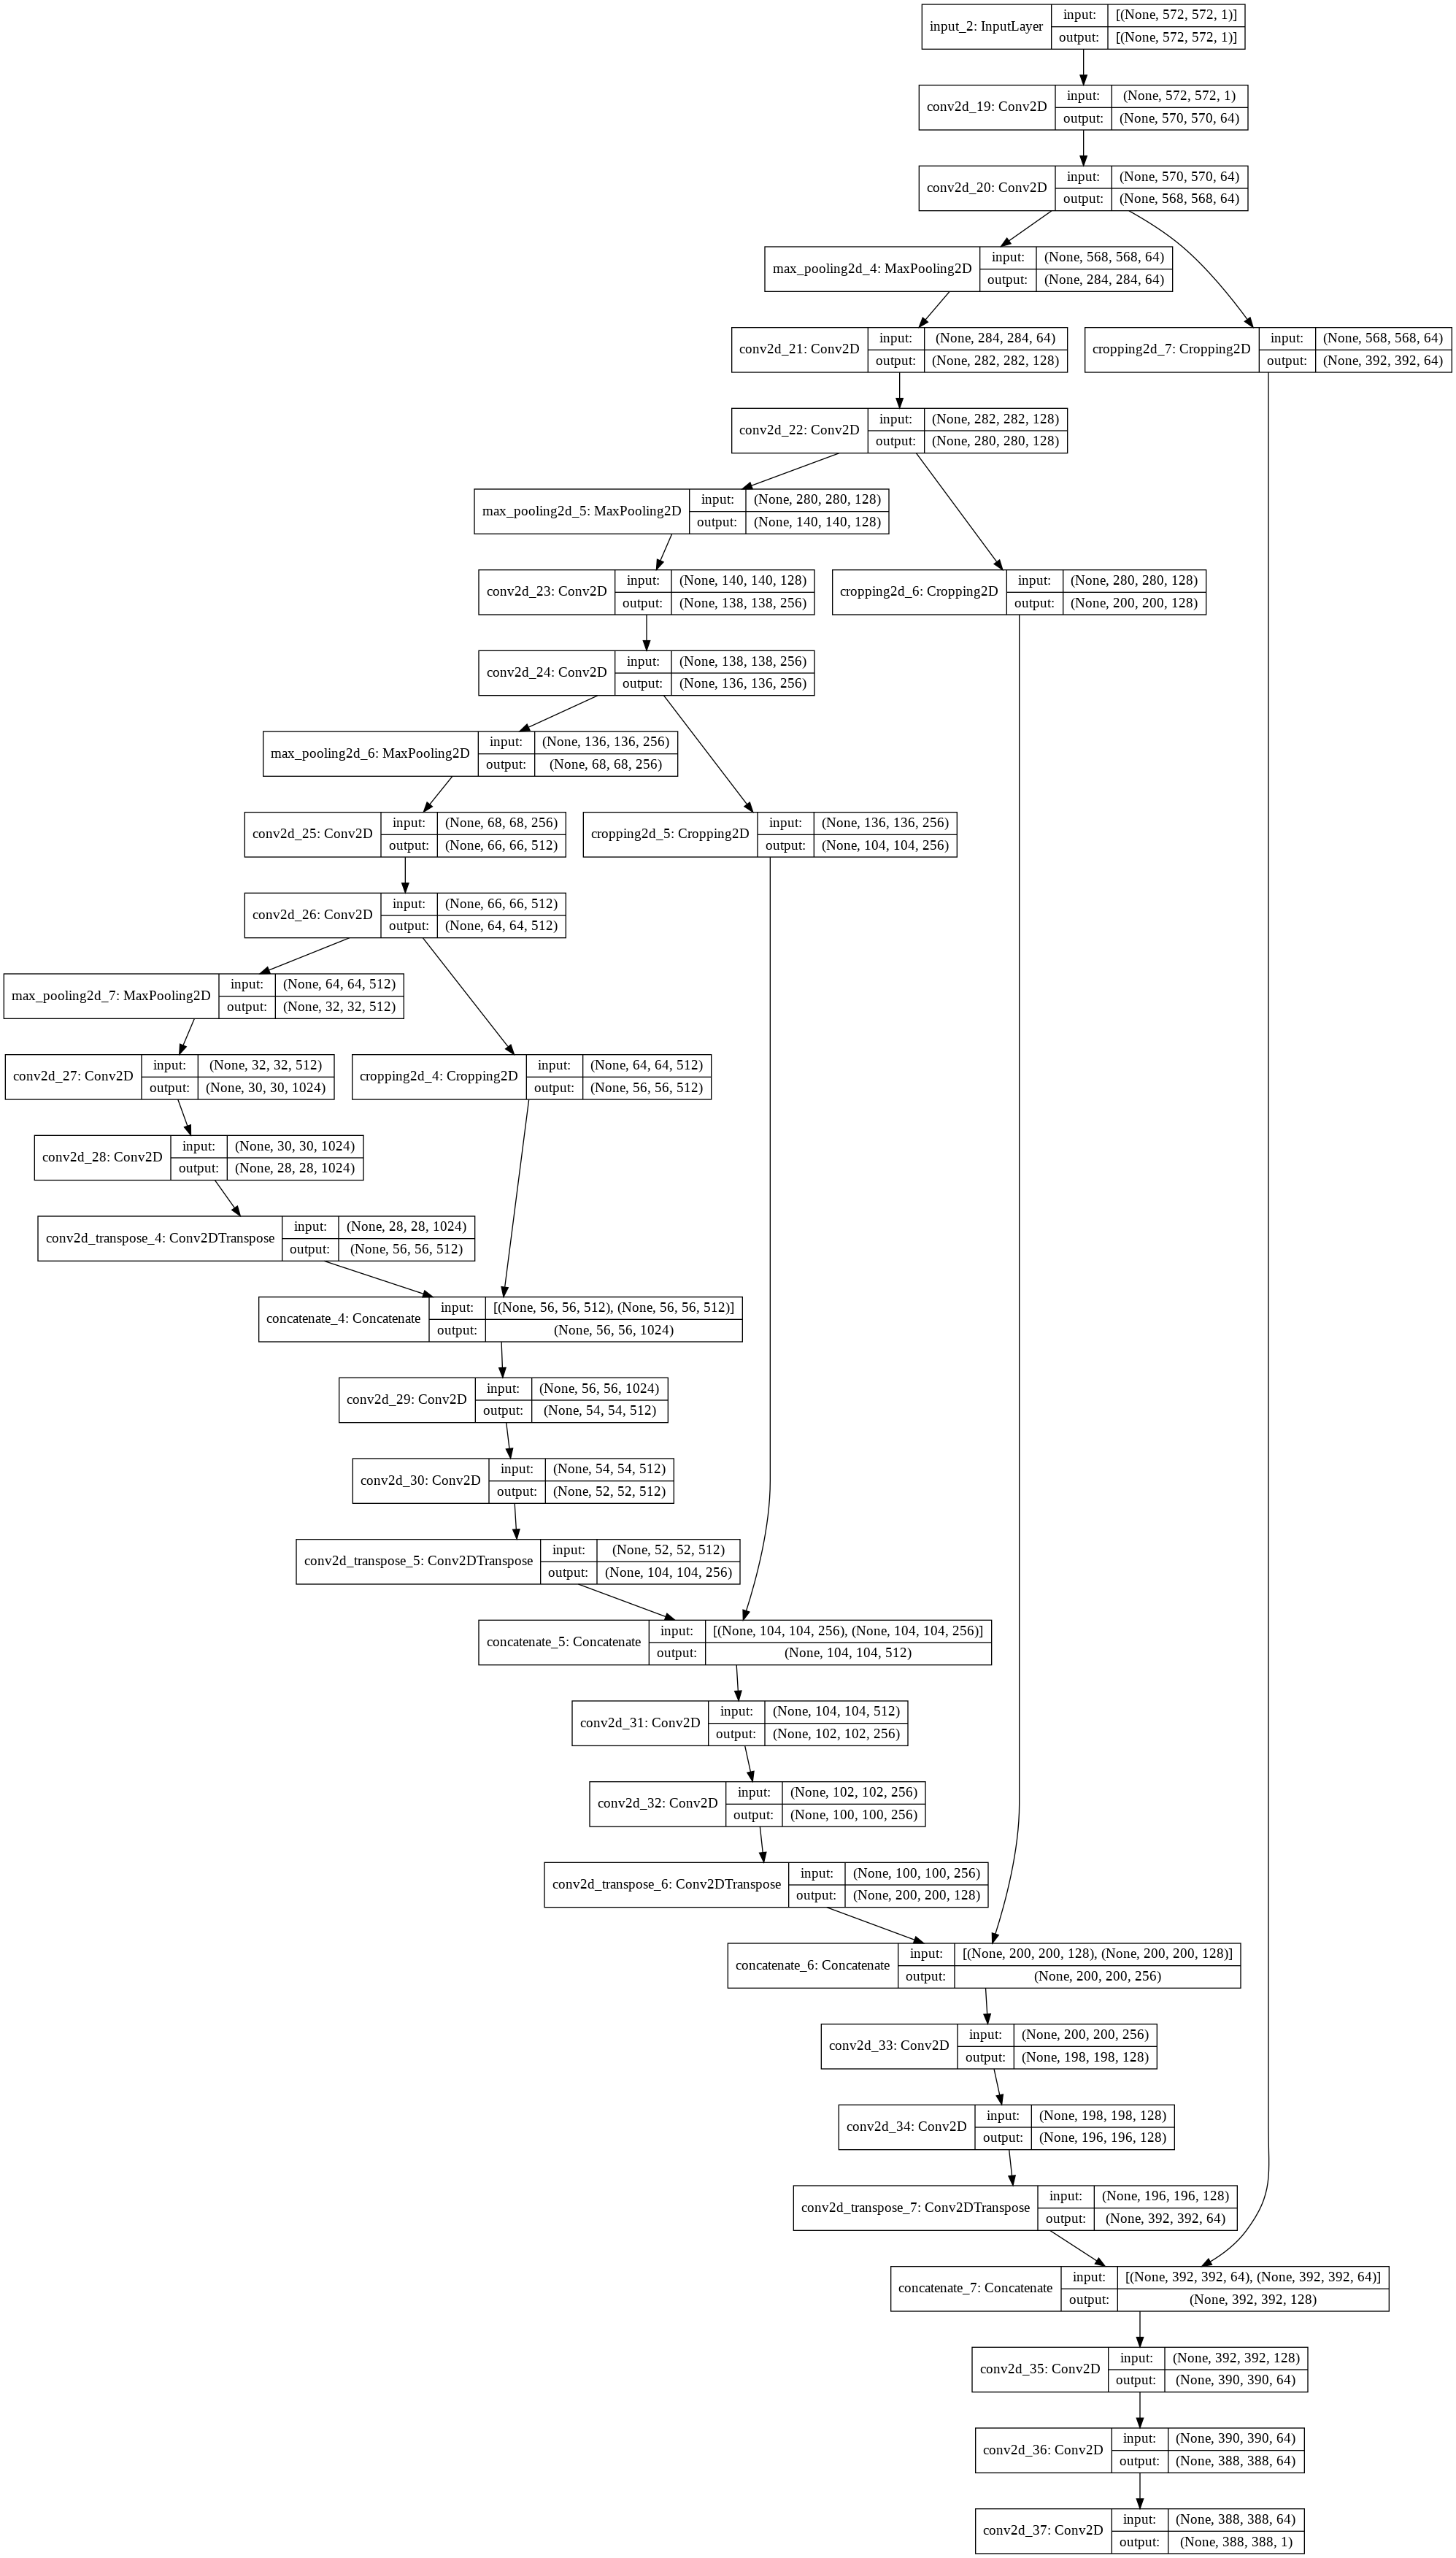

In [36]:
# Plotting the model image
keras.utils.plot_model(model, "model.png", show_shapes=True)

In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 572, 572, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 570, 570, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 568, 568, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 284, 284, 64) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [38]:
# Dice Coefficient
def dice_coefficient(y_true, y_pred):
    num = 2 * tf.reduce_sum(y_true * y_pred)
    dem = tf.reduce_sum(y_true + y_pred) + tf.keras.backend.epsilon()
    
    return num/dem

In [39]:
model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[dice_coefficient,tf.keras.metrics.MeanIoU(num_classes=2)]
)

In [40]:
# Callbacks
filepath="model_save/best_model.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)


earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=np.sqrt(0.1),
                                                 verbose=1,
                                                 patience=2)

In [41]:
callbacks_list =[model_checkpoint_callback,
                 earlystop,
                 reduce_lr,
                ]

In [42]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=10,
                    validation_data=(X_test,y_test),
                    callbacks=callbacks_list,
                    batch_size=1)

Epoch 1/10
24/24 [==============================] - 19s 709ms/step - loss: 1.4023 - dice_coefficient: 0.2553 - mean_io_u_2: 0.3651 - val_loss: 0.5937 - val_dice_coefficient: 0.2878 - val_mean_io_u_2: 0.3806
Epoch 2/10
24/24 [==============================] - 16s 685ms/step - loss: 0.6237 - dice_coefficient: 0.2930 - mean_io_u_2: 0.3662 - val_loss: 0.6054 - val_dice_coefficient: 0.3042 - val_mean_io_u_2: 0.3806
Epoch 3/10
24/24 [==============================] - 16s 687ms/step - loss: 0.6214 - dice_coefficient: 0.3016 - mean_io_u_2: 0.3662 - val_loss: 0.5939 - val_dice_coefficient: 0.2937 - val_mean_io_u_2: 0.3806

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
Epoch 4/10
24/24 [==============================] - 16s 686ms/step - loss: 0.6157 - dice_coefficient: 0.2971 - mean_io_u_2: 0.3662 - val_loss: 0.5888 - val_dice_coefficient: 0.2865 - val_mean_io_u_2: 0.3806
Epoch 5/10
24/24 [==============================] - 16s 684ms/step - loss: 0.6150 - dice_c

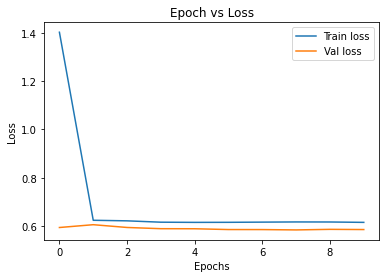

In [43]:
plt.plot(history.epoch,history.history['loss'])
plt.plot(history.epoch,history.history['val_loss'])
plt.title('Epoch vs Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train loss','Val loss']);